In [1]:
import numpy as np
import matplotlib.pylab as plot
from astropy.io import ascii,fits
from scipy import interpolate
import grb_catalogs_copy
from BurstCube.LocSim.Detector import *
from BurstCube.LocSim.Spacecraft import *
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import curve_fit
import math

In [2]:
# read in GBM GRB catalog (first 9 years)
gbm=fits.open('gbmgrbcat_copy.fits')
gbm=gbm[1].data

#randomly select GRBs from GBM catalog in orer to create simulated sample

simsample = gbm[np.random.choice(gbm.shape[0], 5000, replace=True)]


In [3]:
## code to use when reading in GBM effective area in order to get data into the desired format
def getGBMdata(gbmfile=None):
    """Reads the GBM NaI effective area file and returns a numpy array
    with two columns ``energy`` and ``aeff``.
    Parameters
    ----------
    gbmfile : string
       Name of file that contains the GBM data.
    Returns
    ----------
    gbmdata : array 
    numpy array with two columns ``energy`` and ``aeff``
    """
    
    return np.genfromtxt(gbmfile,skip_header=2,names=('energy', 'aeff'))


In [4]:
## bit of useful code for interpolating in log space
def loginterpol(x,y,x1):

    f=interpolate.interp1d(np.log10(x),np.log10(y),bounds_error=False,fill_value="extrapolate",kind='linear')
    y1=10**f(np.log10(x1))

    return y1

def loginterpol2d(x,y,z,x1,y1):

    wz=np.where(z==0)[0]
    zz=z
    zz[wz]=1.
    f=interpolate.interp2d(x,y,np.log10(zz),bounds_error=False,fill_value="extrapolate",kind='linear')
    z1=10**f(x1,y1)

In [5]:
## generate random positions on the sky with equal area probability
def random_sky(n=1):

    u=np.random.rand(n)
    v=np.random.rand(n)

    phi=2*np.pi*u
    theta=np.arccos(2*v-1.)

    dec=-np.degrees(theta-np.pi/2.)
    ra=np.degrees(np.pi*2-phi)

    return ra,dec

In [6]:
## read in the GBM Aeff
aeff_gbm = getGBMdata('/home/alyson/NASA/Simulation/BurstCube/Users/ajoens/gbm_effective_area.dat')

In [7]:
## separate GBM short & long GRBs
w=np.where(gbm['FLUX_1024']>0)
gbm=gbm[w]
s=np.where(gbm['T90'] <= 2.)[0]
l=np.where(gbm['T90'] > 2.)[0]
m=np.where(gbm['PFLX_BEST_FITTING_MODEL'][s] == ' ')
print(np.shape(gbm))

(2351,)


In [8]:
## separate simulated GBM short & long GRBs
wsim=np.where(simsample['FLUX_1024']>0)
simsample=simsample[wsim]
ssim=np.where(simsample['T90'] <= 2.)[0]
lsim=np.where(simsample['T90'] > 2.)[0]
msim=np.where(simsample['PFLX_BEST_FITTING_MODEL'][ssim] == ' ')
print(np.shape(simsample[lsim]))
print(np.shape(simsample[ssim]))
print(np.shape(simsample))

(4158,)
(839,)
(4997,)


In [9]:
#Integrating the best fit spectrum for each GRB in the energy range of 50-300 KeV to get max. observed photon flux. 
#This will give us the photon flux in units of ph/cm^2/s. Currently only doing this for GBM and will then add in BurstCube
# the parts below I have commented out are what I believe are for BC and currently I am focusing on GBM
mo=gbm['PFLX_BEST_FITTING_MODEL'][s]
#f=np.zeros([len(s),nsims]) # produces an array of zeros with the given shape and type
pf=np.zeros(len(s))
gbmcr=np.zeros(len(s))
outE=np.logspace(np.log10(50),np.log10(300),100) # returns numbers spaced evenly on a log scale
for i in range(len(s)):
    #for j in range(nsims):
        #E=np.array(eng[w[j]+1:w[j+1]+1])
        #AeffBC=loginterpol(E,aeffs['aeff'][w[j]+1:w[j+1]+1],outE)
        AeffGBM=loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],outE)#eng[w[j]+1:w[j+1]+1])
        #Aratio=(AeffBC/AeffGBM)
        # not sure what *grb_catalogs_copy.pl(outE,gbm['PFLX_PLAW_INDEX'][s[i]] is and why we need it. I think we only need the model photon flux times the aeffGBM and we want it integrated over the energy range provided in outE
        # this should give us an array of the maximum observed photon flux for GBM
        if mo[i]=='PFLX_PLAW':
            gbmcr[i]=np.trapz(gbm['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs_copy.pl(outE,gbm['PFLX_PLAW_INDEX'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbm['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs_copy.pl(outE,gbm['PFLX_PLAW_INDEX'][s[i]]),outE)
            #pf[i]=gbm['PFLX_PLAW_PHTFLUX'][s[i]]
        if mo[i]=='PFLX_COMP':
            gbmcr[i]=np.trapz(gbm['PFLX_COMP_AMPL'][s[i]]*grb_catalogs_copy.comp(outE,gbm['PFLX_COMP_INDEX'][s[i]],gbm['PFLX_COMP_EPEAK'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbm['PFLX_COMP_AMPL'][s[i]]*grb_catalogs_copy.comp(outE,gbm['PFLX_COMP_INDEX'][s[i]],gbm['PFLX_COMP_EPEAK'][s[i]]),outE)
            #pf[i]=gbm['PFLX_COMP_PHTFLUX'][s[i]]
        if mo[i]=='PFLX_BAND':
            gbmcr[i]=np.trapz(gbm['PFLX_BAND_AMPL'][s[i]]*grb_catalogs_copy.band(outE,gbm['PFLX_BAND_ALPHA'][s[i]],gbm['PFLX_BAND_EPEAK'][s[i]],gbm['PFLX_BAND_BETA'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbm['PFLX_BAND_AMPL'][s[i]]*grb_catalogs_copy.band(outE,gbm['PFLX_BAND_ALPHA'][s[i]],gbm['PFLX_BAND_EPEAK'][s[i]],gbm['PFLX_BAND_BETA'][s[i]]),outE)
            #pf[i]=gbm['PFLX_BAND_PHTFLUX'][s[i]]
        if mo[i]=='PFLX_SBPL':
            gbmcr[i]=np.trapz(gbm['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs_copy.sbpl(outE,gbm['PFLX_SBPL_INDX1'][s[i]],gbm['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbm['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs_copy.sbpl(outE,gbm['PFLX_SBPL_INDX1'][s[i]],gbm['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]]),outE)
            #pf[i]=gbm['PFLX_SBPL_PHTFLUX'][s[i]]

pf = np.array(pf)
gbmcr = np.array(gbmcr)
#print(pf)
sizepf =np.shape(pf)
print(sizepf)

(394,)


In [10]:
#Finding the peak flux and count rate of our simulated sample.
ms=simsample['PFLX_BEST_FITTING_MODEL'][ssim]
#f=np.zeros([len(s),nsims]) # produces an array of zeros with the given shape and type
simpf=np.zeros(len(ssim))
simgbmcr=np.zeros(len(ssim))
outE=np.logspace(np.log10(50),np.log10(300),100) # returns numbers spaced evenly on a log scale
for i in range(len(ssim)):
    #for j in range(nsims):
        #E=np.array(eng[w[j]+1:w[j+1]+1])
        #AeffBC=loginterpol(E,aeffs['aeff'][w[j]+1:w[j+1]+1],outE)
        AeffGBM=loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],outE)#eng[w[j]+1:w[j+1]+1])
        #Aratio=(AeffBC/AeffGBM)
        # not sure what *grb_catalogs_copy.pl(outE,gbm['PFLX_PLAW_INDEX'][s[i]] is and why we need it. I think we only need the model photon flux times the aeffGBM and we want it integrated over the energy range provided in outE
        # this should give us an array of the maximum observed photon flux for GBM
        if ms[i]=='PFLX_PLAW':
            simgbmcr[i]=np.trapz(simsample['PFLX_PLAW_AMPL'][ssim[i]]*grb_catalogs_copy.pl(outE,simsample['PFLX_PLAW_INDEX'][ssim[i]])*AeffGBM,outE)
            simpf[i]=np.trapz(simsample['PFLX_PLAW_AMPL'][ssim[i]]*grb_catalogs_copy.pl(outE,simsample['PFLX_PLAW_INDEX'][ssim[i]]),outE)
        if ms[i]=='PFLX_COMP':
            simgbmcr[i]=np.trapz(simsample['PFLX_COMP_AMPL'][ssim[i]]*grb_catalogs_copy.comp(outE,simsample['PFLX_COMP_INDEX'][ssim[i]],simsample['PFLX_COMP_EPEAK'][ssim[i]])*AeffGBM,outE)
            simpf[i]=np.trapz(simsample['PFLX_COMP_AMPL'][ssim[i]]*grb_catalogs_copy.comp(outE,simsample['PFLX_COMP_INDEX'][ssim[i]],simsample['PFLX_COMP_EPEAK'][ssim[i]]),outE)
            #pf[i]=gbm['PFLX_COMP_PHTFLUX'][s[i]]
        if ms[i]=='PFLX_BAND':
            simgbmcr[i]=np.trapz(simsample['PFLX_BAND_AMPL'][ssim[i]]*grb_catalogs_copy.band(outE,simsample['PFLX_BAND_ALPHA'][ssim[i]],simsample['PFLX_BAND_EPEAK'][ssim[i]],simsample['PFLX_BAND_BETA'][ssim[i]])*AeffGBM,outE)
            simpf[i]=np.trapz(simsample['PFLX_BAND_AMPL'][ssim[i]]*grb_catalogs_copy.band(outE,simsample['PFLX_BAND_ALPHA'][ssim[i]],simsample['PFLX_BAND_EPEAK'][ssim[i]],simsample['PFLX_BAND_BETA'][ssim[i]]),outE)
            #pf[i]=gbm['PFLX_BAND_PHTFLUX'][s[i]]
        if ms[i]=='PFLX_SBPL':
            simgbmcr[i]=np.trapz(simsample['PFLX_SBPL_AMPL'][ssim[i]]*grb_catalogs_copy.sbpl(outE,simsample['PFLX_SBPL_INDX1'][ssim[i]],simsample['PFLX_SBPL_BRKEN'][ssim[i]],simsample['PFLX_SBPL_INDX2'][ssim[i]])*AeffGBM,outE)
            simpf[i]=np.trapz(simsample['PFLX_SBPL_AMPL'][ssim[i]]*grb_catalogs_copy.sbpl(outE,simsample['PFLX_SBPL_INDX1'][ssim[i]],simsample['PFLX_SBPL_BRKEN'][ssim[i]],simsample['PFLX_SBPL_INDX2'][ssim[i]]),outE)
            #pf[i]=gbm['PFLX_SBPL_PHTFLUX'][s[i]]

simpf = np.array(simpf)
simgbmcr = np.array(simgbmcr)
sizepf =np.shape(simpf)
#print(sizepf)
#print(simpf)
#print(np.shape(simgbmcr))

(839,)
[  1.67150145   2.13382745   2.52680473   2.8798524    0.
   0.9142115   24.36121543   1.84464744   1.9092975    0.
   1.82843825 153.35742652   9.49313869   0.           4.2494674
   2.64209313   3.01928408   0.           0.9142115    2.17232852
   8.12568731   8.12568731   2.97944567   2.03245458   2.16273664
   1.83137709   6.08862075   1.89394069   6.47549901   2.57170097
   0.          23.1362036    9.65588037   2.34201578   3.68668037
  10.48758968   9.65588037   0.           5.47256101   0.
   1.86709117   5.68439258   1.8584355    1.70111285   1.878372
   1.52815629   1.6411589    2.11286919   4.69728652   7.0429703
   3.57611198   5.75700366   1.95144853   1.70974133   2.16056664
   2.17232852   0.           4.2494674   12.98787042  78.40539405
   3.63168449   7.6726364    7.59656757  18.17226898   1.11715509
   2.1421402   44.28715944  61.37734968  16.13862078   1.32025267
   3.84079642   2.79717951   9.42237704  18.03267794   2.57592575
   3.29652791  25.93208918   4.

(394,)


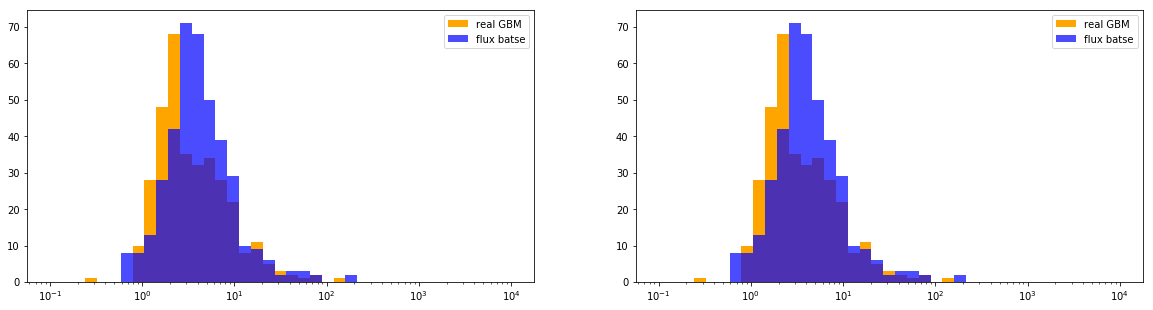

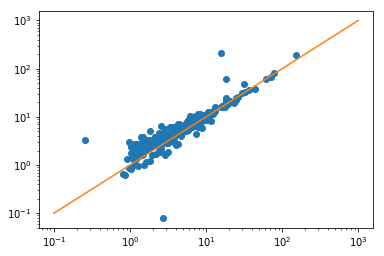

In [11]:
#plot Batse[64] against pf to see if they are the same
flux=gbm['FLUX_BATSE_64'][s]
fluxshape=np.shape(flux)
print(fluxshape)

#Creating plot of peak flux versus counts for real and simulated GBM
#print(np.log10(pf[w]))
fig=plot.figure(figsize=(20,5))
plot.subplot(1,2,1)
plot.hist(pf,label='real GBM',bins=np.logspace(-1,4,40),color='orange')
plot.hist(flux,label='flux batse',bins=np.logspace(-1,4,40),alpha=0.7,color='blue')
plot.xscale('log')
plot.legend()
plot.subplot(1,2,2)
#plot.hist(flux,label='All',bins=np.logspace(-1,2,40),color='green')
#pf has been gathered from the GBM catalog
plot.hist(pf,label='real GBM',bins=np.logspace(-1,4,40),color='orange')
# this is the simulated GBM
plot.hist(flux,label='flux batse',bins=np.logspace(-1,4,40),alpha=0.7,color='blue')
#plot.hist(flux[w],label='BC',bins=np.logspace(-1,2,40),alpha=0.7,color='red')
plot.xscale('log')
plot.legend()

plot.show()

plot.plot(pf,flux, linestyle='None', marker='o')
plot.xscale('log')
plot.yscale('log')
plot.plot([1e-1,1e3],[1e-1,1e3])
plot.show()

In [12]:
# we want to solve for the number of detected counts. We need to create two more arrays- 1 for exposure and the other for interval.
#Interval is given in the GBM catalog however we need to know exposure. This should be found from the exposure map for each burst.
#this all together will give us the number of source photons

## setup GBM
gbm_pointings = {'01': ('45:54:0','20:36:0'),
            '02': ('45:6:0','45:18:0'),
            '03': ('58:24:0','90:12:0'),
            '04': ('314:54:0','45:12:0'),
            '05': ('303:12:0','90:18:0'),
            '06': ('3:24:0','89:48:0'),
            '07': ('224:54:0','20:24:0'),
            '08': ('224:36:0','46:12:0'),
            '09': ('236:36:0','90:0:0'),
            '10': ('135:12:0','45:36:0'),
            '11': ('123:42:0','90:24:0'),
            '12': ('183:42:0','90:18:0')}

fermi = Spacecraft(gbm_pointings,window=0.1)

res = 250
rr,dd = np.meshgrid(np.linspace(0,360,res,endpoint=False),np.linspace(-90,90,res))
exposure_positions = np.vstack([rr.ravel(),dd.ravel()])
gbm_exposures = np.array([[ detector.exposure(position[0],position[1]) for position in exposure_positions.T] 
                      for detector in fermi.detectors])

In [13]:
#using SkyCoord to convert coordinates to degrees and solve for distances.
def separation(ra1,dec1,ra2,dec2):

    c=SkyCoord(ra=ra1*u.deg,dec=dec1*u.deg)
    d=SkyCoord(ra=ra2*u.deg,dec=dec2*u.deg)
    dist=c.separation(d)
    dist=dist.value

    return dist

In [14]:
# now that GBM's pointings are set up we will throw GRBs at it and determine it's exposure for each GRB. 
#generate GRBs and throw them at GBM

def throw_grbs(fermi,minflux,maxflux):
    
    nsims=int(np.round(len(simgbmcr))) #why is nsims length of pf*2?
    ra,dec=random_sky(nsims)
    ra=np.array(ra)-180
    dec=np.array(dec)
    #sigma=0.65,mean=1.5
 
    #change the sigma and mean in order to create a log fit for simulated GBM. Automate this fit.
    #flux=np.random.lognormal(size=nsims,sigma=0.55,mean=0.6)*(np.log10(maxflux)-np.log10(minflux))+np.log10(minflux)

    #GBM exposures for each random GRB. Believe this is an array with the different exposures for each detector
    randgbmexposures = np.array([[detector.exposure(ra[i],dec[i]) for i in range(nsims)] for detector in fermi.detectors])
   # print("randgbmexposures=", randgbmexposures)

    #Order randgbmexposures into descending order
    for column in randgbmexposures.T:
        newrandgbm = -np.sort(-randgbmexposures.T) 
    gbmexposures = np.transpose(newrandgbm)
  #  print("gbmexposures=",gbmexposures)

    #Select the second highest value. 
    #We will use this to ensure the second highest exposure detector has a sig >4.5
    secondhighest = gbmexposures[1,:]
   # print("Second highest =", secondhighest)

        
    return gbmexposures, secondhighest, randgbmexposures

In [15]:
#define the peak flux interval
interval = simsample['PFLX_SPECTRUM_STOP'][ssim]-simsample['PFLX_SPECTRUM_START'][ssim]
print(interval)
#interval = gbm['PFLX_SPECTRUM_STOP'][s]-gbm['PFLX_SPECTRUM_START'][s]
#print the interval of only the short bursts
#print(interval[s])
w=np.shape(interval)
#print(w)
interval=np.array(interval)

[0.064 0.064 0.064 0.064 0.    0.064 0.064 0.064 0.064 0.    0.064 0.064
 0.064 0.    0.064 0.064 0.064 0.    0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.    0.064 0.064 0.064 0.064 0.064
 0.064 0.    0.064 0.    0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.    0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.    0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.    0.064 0.    0.064 0.
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.    0.064 0.064 0.064 0.
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.    0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.064 0.    0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.064 0.    0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.    0.    0.064 0.    0.064 0.064 0.064 0.064 0.064 0.064
 0.064 0.064 0.064 0.064 0.    0.    0.    0.064 0.064 0.

In [16]:
#flux=simpf this is in ph/sec
#flux=simsample['FLUX_BATSE_64'][ssim]
flux=simpf
minflux=min(flux)
maxflux=max(flux)
gbmexposures, secondhighest, randgbmexposures = throw_grbs(fermi,minflux,maxflux)

sechighestsize=np.shape(secondhighest)
print(sechighestsize)
#execute function defined above
#throw_grbs(fermi,minflux,maxflux,pf)

(839,)


In [17]:
print(np.shape(ssim))
print(np.shape(secondhighest))
print(np.shape(interval))

(839,)
(839,)
(839,)


In [18]:
#Solve for the number of detected counts which will equal our source photons
#Should this really be multiplied by pf or should it be multiplied by flux? pf is calculated from GBM catalog#
#Interval is already only for the short bursts so no need to index over short bursts
#Do we want the photons from the source to be calculated from countrate or flux?
source=np.zeros(len(ssim))
for i in range(len(ssim)):
    source[i] = simgbmcr[i]*secondhighest[i]*interval[i]
#print(source)


In [19]:
#Assuming a background count rate. units: cts/s
bckgrd= 1000
#scale the background count rate 
scaledbckgrd = bckgrd*secondhighest*interval
#print(scaledbckgrd)

In [20]:
#calculate the significance of the second highest exposure detector. If the significance is greater than 4.5 sigma than the burst is detectable.
#creating an array of zeros that I can

detect = np.zeros(len(secondhighest))
for i in range(len(secondhighest)):
    sig = source[i] / (math.sqrt(source[i] + scaledbckgrd[i]))
    if sig > 4.5:
        detect[i] = 1.0
    else:
        detect[i] = 0.0

#print(detect)

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

/home/alyson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


[  0   1   4   5   7   8  10  11  12  13  14  15  16  17  18  20  21  22
  24  25  26  28  29  30  31  32  33  34  35  36  37  38  40  41  42  43
  44  46  47  48  49  51  52  53  54  55  56  57  58  59  63  64  65  66
  67  68  69  70  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  90  92  93  94  96  97  99 100 101 102 103 104 105 106 108
 109 110 111 113 114 115 116 117 118 120 121 123 124 125 126 127 128 129
 130 131 132 133 134 136 137 138 140 141 142 143 144 145 146 148 149 150
 151 152 153 154 155 156 158 159 160 161 162 163 164 165 166 168 169 170
 171 172 173 174 175 176 177 178 179 181 183 184 185 186 187 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 214 215 216 217 218 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 236 237 238 239 240 241 242 244 245 246 247 248 251
 252 253 254 255 256 257 258 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 280 281 282 283 284 28

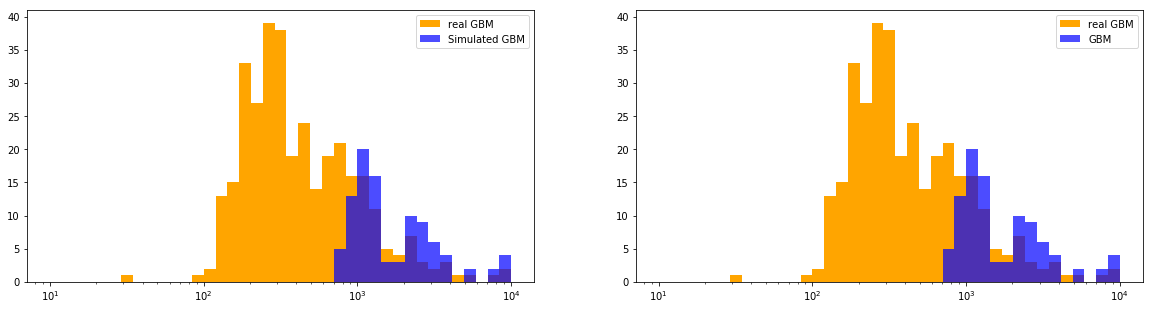

In [21]:
#Creating plot of peak flux versus counts for real and simulated GBM
w=np.where(gbmcr>0)[0]
print(w)
print(np.shape(w))
#The following line gets me a spectrum that is very similar to real gbm's but does not take into account the significance
wg = np.where((simgbmcr*detect)>0)[0]
#print(wg)
#print(np.shape(wg))
#w=np.where(pf>0)[0]
#wg = np.where(simgbmpf*detect>0)[0]
#print(np.log10(pf[w]))
fig=plot.figure(figsize=(20,5))
plot.subplot(1,2,1)
plot.hist(gbmcr[w],label='real GBM',bins=np.logspace(1,4,40),color='orange')
plot.hist((simgbmcr*detect),label='Simulated GBM',bins=np.logspace(1,4,40),alpha=0.7,color='blue')
#plot.hist(simgbmcr[wg],label='Simulated GBM',bins=np.logspace(1,4,40),alpha=0.7,color='blue')
plot.xscale('log')
plot.legend()
plot.subplot(1,2,2)
#plot.hist(flux,label='All',bins=np.logspace(-1,2,40),color='green')
#pf has been gathered from the GBM catalog
plot.hist(gbmcr[w],label='real GBM',bins=np.logspace(1,4,40),color='orange')
# this is the simulated GBM
plot.hist(simgbmcr[wg],label='GBM',bins=np.logspace(1,4,40),alpha=0.7,color='blue')
#plot.hist(flux[w],label='BC',bins=np.logspace(-1,2,40),alpha=0.7,color='red')
plot.xscale('log')
plot.legend()

plot.show()
        